In [100]:
keras.backend.clear_session()

In [35]:
from IPython.display import Image
from IPython.core.display import HTML 
from collections import Counter

import cv2
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt #for plotting things
import os
import os.path
import shutil
import seaborn as sns
import joblib

# Keras Libraries
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.metrics import classification_report, confusion_matrix
#from keras.models import model_from_json
from tensorflow.keras.models import load_model
from keras.utils import plot_model

In [2]:
train_images = r"C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\train"
val_images = r"C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\val"
test_images = r"C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\test"

#### This function serves to feed in the from the train, validation and test image datasets, label them appropiately as a 0 or a 1 based on their location (either in the Pneumonia or Normal files). Then, it iterates through the images, converts them to grayscale, resizes the image to a smaller 128 x 128 dimension and converts it into an array of numbers. This list of pixels, along with the label (0 or 1), is then appended into the an array. 

In [3]:
labels = ['PNEUMONIA', 'NORMAL', 'COVID']

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        print(path)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), 
                                     cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (128, 128))
                data.append([resized_arr, class_num])
            
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
train = get_training_data(r"C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\train")
val = get_training_data(r"C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\val")
test = get_training_data(r"C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\test")

C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\train\PNEUMONIA
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\train\NORMAL
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\train\COVID
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\val\PNEUMONIA
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\val\NORMAL
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\val\COVID
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\test\PNEUMONIA
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\test\NORMAL
C:\Users\Gareth\Desktop\Ironhack\Week_Eight\Project_Datasets\chest_xray\test\COVID


#### Here's the distribution of our images per set.
#### I have now included additional CT scans from COVID-19 patients in the dataset.

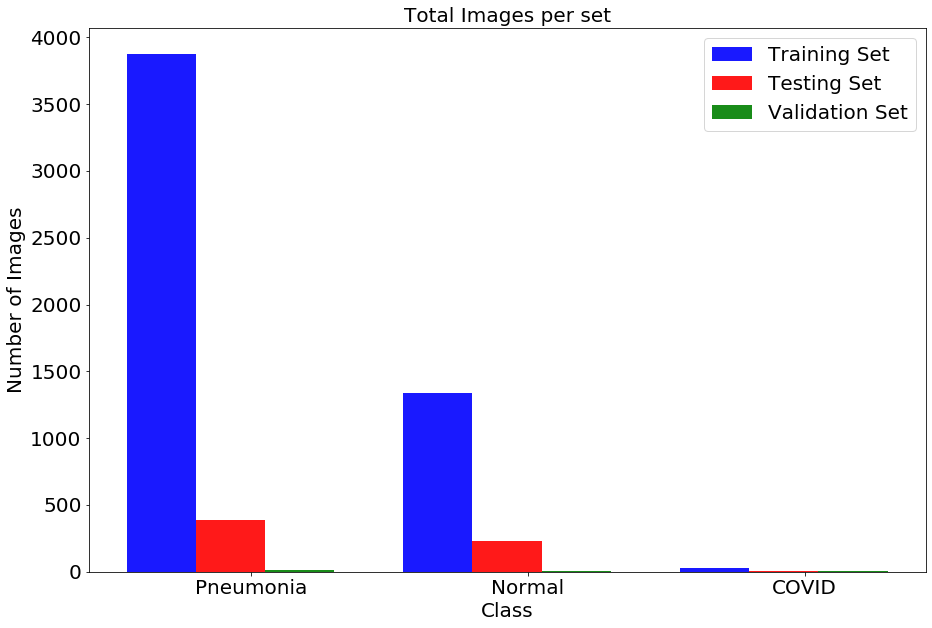

In [77]:
train_cases = pd.DataFrame(train)
test_cases = pd.DataFrame(test)
val_cases = pd.DataFrame(val)

train_cases = train_cases[1].value_counts()
test_cases = test_cases[1].value_counts()
val_cases = val_cases[1].value_counts()

labels = ['PNEUMONIA', 'NORMAL', 'COVID']

index = np.arange(len(labels))
bar_width = 0.25
opacity = 0.9

fig, ax = plt.subplots(figsize = (15, 10))

train_bar = ax.bar(index - bar_width, train_cases, bar_width,
                alpha=opacity, color='b',
                label='Training Set')

test_bar = ax.bar(index, test_cases, bar_width,
                alpha=opacity, color='r', tick_label = ('Pneumonia', 'Normal', 'COVID'),
                label='Testing Set')
val_bar = ax.bar(index + bar_width, val_cases, bar_width,
                  alpha=opacity, color='g', tick_label = ('Pneumonia', 'Normal', 'COVID'),
                label='Validation Set')


plt.xlabel('Class', fontsize = 20)
plt.ylabel('Number of Images', fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Total Images per set', fontsize = 20)
plt.xticks(index + 0.3 *  bar_width, fontsize = 20)
plt.legend(fontsize = 20)

plt.show()

#### Here's a further breakdown of the how the images are distributed in the set.

In [44]:
def percentage(image_set):
    for l, i in zip(labels, list(image_set)):
        num = (int(i) / sum(list(image_set)))
        print(l,' images make up ',round(num * 100),'% of the set')

In [45]:
percentage(train_cases)

PNEUMONIA  images make up  74 % of the set
NORMAL  images make up  26 % of the set
COVID  images make up  1 % of the set


In [46]:
percentage(test_cases)

PNEUMONIA  images make up  62 % of the set
NORMAL  images make up  37 % of the set
COVID  images make up  1 % of the set


In [47]:
percentage(val_cases)

PNEUMONIA  images make up  38 % of the set
NORMAL  images make up  31 % of the set
COVID  images make up  31 % of the set


#### As mentioned in the previous notebook, our dataset is quite unbalanced, which might affect the fit of the CNN. In order to avoid this, I will use the ImageDataGenerator, which I will describe later.

## Preparing the image data for implementation into our CNN.

#### Here, I extract the feature (the numpy array per image), and the label (the class of the image), and append the data into x and y sets.  

In [5]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [6]:
x_train[0]

array([[19, 27, 30, ..., 16,  9,  2],
       [24, 26, 34, ..., 17, 11,  4],
       [22, 30, 39, ..., 19, 11,  4],
       ...,
       [10,  8,  7, ..., 15, 15, 15],
       [10,  8,  7, ..., 15, 15, 15],
       [10, 10,  7, ..., 15, 15, 15]], dtype=uint8)

### Reducing the Colour Data Down to Grayscale (0 - 1) instead of (0 - 255)

#### This significantly reduces the amount of information that the neural network needs to process, thereby reducing the amount of data that's needed to be allocated to memory and reducing the computation time.

In [7]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [8]:
img_size = 128

In [9]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [10]:
y_val

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2])

In [11]:
print(x_train.shape)

(5244, 128, 128, 1)


In [12]:
x_train[0]

array([[[0.0745098 ],
        [0.10588235],
        [0.11764706],
        ...,
        [0.0627451 ],
        [0.03529412],
        [0.00784314]],

       [[0.09411765],
        [0.10196078],
        [0.13333333],
        ...,
        [0.06666667],
        [0.04313725],
        [0.01568627]],

       [[0.08627451],
        [0.11764706],
        [0.15294118],
        ...,
        [0.0745098 ],
        [0.04313725],
        [0.01568627]],

       ...,

       [[0.03921569],
        [0.03137255],
        [0.02745098],
        ...,
        [0.05882353],
        [0.05882353],
        [0.05882353]],

       [[0.03921569],
        [0.03137255],
        [0.02745098],
        ...,
        [0.05882353],
        [0.05882353],
        [0.05882353]],

       [[0.03921569],
        [0.03921569],
        [0.02745098],
        ...,
        [0.05882353],
        [0.05882353],
        [0.05882353]]])

### ImageDataGenerator
#### This parameter can be used to generate more data from our dataset by feeding in images and manipulating them by flipping their horizontal axis or rotating them. This serves as a way to artificially increase the size of our dataset. This is applied to both the Training Data and Validation Data.

In [13]:
datagen = ImageDataGenerator(horizontal_flip = True,
                             rotation_range = 5,
                            zoom_range = 0.1,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2)

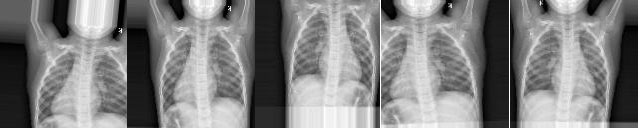

# CNN Model

### Below I utilised the same model as I used in my previous notebook to assess wherever this can differentiate between COVID-19 induced pneumonia and the previous pneumonia images.

In [96]:
model = Sequential()

#Convolution 
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 1)))

#Pooling
model.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
model.add(Conv2D(64, (3, 3), activation="relu"))

# 2nd Pooling layer
model.add(MaxPooling2D(pool_size = (2, 2)))

# 3rd Convolution
#model.add(Conv2D(128, (3, 3), activation="relu"))

# 3rd Pooling layer
#model.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten the layer - this flattens the 3D feature maps into 1D 
# feature vectors.
model.add(Flatten())

# Density
model.add(Dense(activation = 'relu', units = 2048, kernel_initializer = 'uniform'))
model.add(Dense(activation = 'relu', units = 1024, kernel_initializer = 'uniform'))
model.add(Dense(activation = 'relu', units = 512, kernel_initializer = 'uniform'))
model.add(Dense(activation = 'relu', units = 265, kernel_initializer = 'uniform'))
model.add(Dense(activation = 'sigmoid', units = 1, kernel_initializer = 'uniform'))

# Compile 
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [97]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              117966848 
_________________________________________________________________
dense_7 (Dense)              (None, 1024)             

In [88]:
model_covid = model.fit(datagen.flow(x_train, y_train, batch_size = 128), epochs = 20,
                                  validation_data = datagen.flow(x_val, y_val))

Epoch 1/20
41/41 [==============================] - 91s 2s/step - loss: 0.5915 - accuracy: 0.7386 - val_loss: 1.9217 - val_accuracy: 0.3077
Epoch 2/20
41/41 [==============================] - 87s 2s/step - loss: 0.4561 - accuracy: 0.7849 - val_loss: 1.8062 - val_accuracy: 0.4231
Epoch 3/20
41/41 [==============================] - 86s 2s/step - loss: 0.3484 - accuracy: 0.8501 - val_loss: 0.9598 - val_accuracy: 0.4231
Epoch 4/20
41/41 [==============================] - 86s 2s/step - loss: 0.3026 - accuracy: 0.8711 - val_loss: 0.6621 - val_accuracy: 0.5000
Epoch 5/20
41/41 [==============================] - 87s 2s/step - loss: 0.2449 - accuracy: 0.8926 - val_loss: 1.7197 - val_accuracy: 0.3846
Epoch 6/20
41/41 [==============================] - 86s 2s/step - loss: 0.2358 - accuracy: 0.8963 - val_loss: 0.1177 - val_accuracy: 0.4231
Epoch 7/20
41/41 [==============================] - 93s 2s/step - loss: 0.2063 - accuracy: 0.9081 - val_loss: -0.2496 - val_accuracy: 0.5385
Epoch 8/20
41/41 [=

### As you can see, the accuracy of the model is quite good at 87%, whilst the losses could be improved with further tweaking of the CNN.

In [89]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

632/632 [==============================] - 3s 4ms/step
Loss of the model is -  30.369769734672353 %
632/632 [==============================] - 3s 4ms/step
Accuracy of the model is -  87.1835470199585 %


In [90]:
print("training_accuracy", model_covid.history['accuracy'][-1])
print("validation_accuracy", model_covid.history['val_accuracy'][-1])

training_accuracy 0.9054157
validation_accuracy 0.5384615659713745


In [91]:
predictions = model_new.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [92]:
correct_class = []
incorrect_class = []
correct = []
incorrect = []

for i, y in (zip(predictions, y_test)):
    
    if i == y:
        correct.append(1)
        correct_class.append(i)
    
    elif i != y:
        incorrect.append(1)
        incorrect_class.append(y)
        
print('Number of correct predictions:', sum(correct))
print('Number of incorrect predictions:', sum(incorrect))

Number of correct predictions: 532
Number of incorrect predictions: 100


In [93]:
corr = Counter(correct_class)
incorr = Counter(incorrect_class)
corr = list(corr.values())
incorr = list(incorr.values())

In [94]:
print('Number of Pneumonia Cases correctly guessed:', corr[0])
print('Number of Normal Cases correctly guessed:', corr[1])
print('Number of COVID Cases correctly guessed: 0')
print('Number of Pneumonia Cases incorrectly guessed:', incorr[0])
print('Number of Normal Cases incorrectly guessed:', incorr[1])
print('Number of COVID Cases incorrectly guessed:', incorr[2])

Number of Pneumonia Cases correctly guessed: 371
Number of Normal Cases correctly guessed: 161
Number of COVID Cases correctly guessed: 0
Number of Pneumonia Cases incorrectly guessed: 19
Number of Normal Cases incorrectly guessed: 73
Number of COVID Cases incorrectly guessed: 8


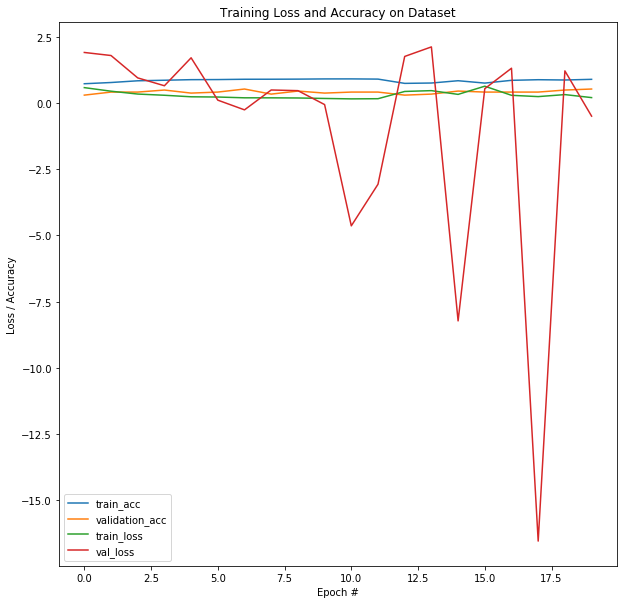

In [95]:
plt.figure(figsize = (10,10))
plt.plot(model_covid.history['accuracy'], label = "train_acc")
plt.plot(model_covid.history['val_accuracy'], label = "validation_acc")
plt.plot(model_covid.history['loss'], label = "train_loss")
plt.plot(model_covid.history['val_loss'], label = "val_loss")
plt.title('Training Loss and Accuracy on Dataset')
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='lower left')
plt.show()

### Below is the confusion matrix for this CNN. As you can see, the model has issues distinguishing between COVID-19 Pneumonia and regular Pneumonia. This makes sense because the number of COVID-19 Pneumonia images are far smallerthan the regular Pneumonia dataset. In addition, as the two types of pneumonia are similar (viral induced), it would be difficult for the model to distinguish.

### On a positive note, this highlights the ability for the dataset to track pneumonia in new images, and classify them. With a larger set of images, this could be further improved.

In [25]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)', 'COVID (Class 2)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.90      0.91      0.91       390
   Normal (Class 1)       0.84      0.86      0.85       234
    COVID (Class 2)       0.00      0.00      0.00         8

           accuracy                           0.88       632
          macro avg       0.58      0.59      0.58       632
       weighted avg       0.87      0.88      0.87       632



In [26]:
cm = confusion_matrix(y_test,predictions)
cm

array([[354,  36,   0],
       [ 33, 201,   0],
       [  5,   3,   0]], dtype=int64)

In [27]:
cm_df = pd.DataFrame(cm , index = ['0','1','2'] , columns = ['0','1','2'])

In [72]:
model.save('model_PNEUCOVIDCOMPARE_attempt1 24.05.2020.model')
model.save_weights('model_PNEUCOVIDCOMPARE_attempt1 24.05.2020.h5')

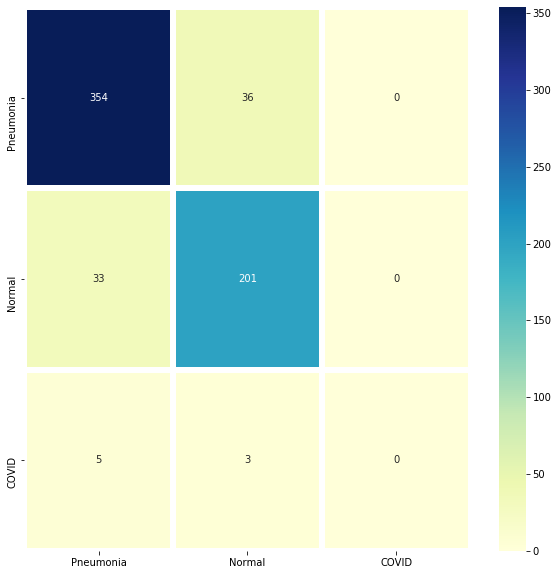

In [28]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_df, linewidth = 5 , annot = True, fmt='d',
           xticklabels = ['Pneumonia', 'Normal', 'COVID'],
           yticklabels = ['Pneumonia', 'Normal', 'COVID'],
           cmap="YlGnBu")

### In order to further develop the model, I decided to reduce the learning rate in order to reduce the losses.

In [14]:
model2 = Sequential()

#Convolution 
model2.add(Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 1)))

#Pooling
model2.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
model2.add(Conv2D(64, (3, 3), activation="relu"))

# 2nd Pooling layer
model2.add(MaxPooling2D(pool_size = (2, 2)))

# 3rd Convolution
#model.add(Conv2D(128, (3, 3), activation="relu"))

# 3rd Pooling layer
#model.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten the layer - this flattens the 3D feature maps into 1D 
# feature vectors.
model2.add(Flatten())

# Density
model2.add(Dense(activation = 'relu', units = 2048, kernel_initializer = 'uniform'))
model2.add(Dense(activation = 'relu', units = 1024, kernel_initializer = 'uniform'))
model2.add(Dense(activation = 'relu', units = 512, kernel_initializer = 'uniform'))
model2.add(Dense(activation = 'relu', units = 265, kernel_initializer = 'uniform'))
model2.add(Dense(activation = 'sigmoid', units = 1, kernel_initializer = 'uniform'))

# Compile
optimizer = keras.optimizers.Adam(lr=0.001)
model2.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [16]:
model_covid = model2.fit(datagen.flow(x_train, y_train, batch_size = 128), epochs = 10,
                                  validation_data = datagen.flow(x_val, y_val),
                       shuffle = True)

Epoch 1/10
41/41 [==============================] - 110s 3s/step - loss: 0.5817 - accuracy: 0.7357 - val_loss: 1.4785 - val_accuracy: 0.3077
Epoch 2/10
41/41 [==============================] - 118s 3s/step - loss: 0.4729 - accuracy: 0.7927 - val_loss: 2.7612 - val_accuracy: 0.4231
Epoch 3/10
41/41 [==============================] - 113s 3s/step - loss: 0.3102 - accuracy: 0.8600 - val_loss: 2.2752 - val_accuracy: 0.4615
Epoch 4/10
41/41 [==============================] - 119s 3s/step - loss: 0.2489 - accuracy: 0.8965 - val_loss: 0.6574 - val_accuracy: 0.5000
Epoch 5/10
41/41 [==============================] - 96s 2s/step - loss: 0.2293 - accuracy: 0.8995 - val_loss: 0.5561 - val_accuracy: 0.5000
Epoch 6/10
41/41 [==============================] - 90s 2s/step - loss: 0.2104 - accuracy: 0.9077 - val_loss: 0.8407 - val_accuracy: 0.3846
Epoch 7/10
41/41 [==============================] - 91s 2s/step - loss: 0.1966 - accuracy: 0.9136 - val_loss: 0.4712 - val_accuracy: 0.3846
Epoch 8/10
41/41

In [17]:
print("Loss of the model is - " , model2.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model2.evaluate(x_test,y_test)[1]*100 , "%")

632/632 [==============================] - 3s 5ms/step
Loss of the model is -  35.944573411458656 %
632/632 [==============================] - 3s 4ms/step
Accuracy of the model is -  87.8164529800415 %


In [20]:
print("training_accuracy", model2.history.history['accuracy'][-1])
print("validation_accuracy", model2.history.history['val_accuracy'][-1])

training_accuracy 0.9044622
validation_accuracy 0.42307692766189575


### Whilst the amount that the validation loss fluctuates has reduced, the validation accuracy percentage has decreased and the overall loss of the model has increase. This suggests that decreasing the learning rate may be resulting in overfitting of the model.

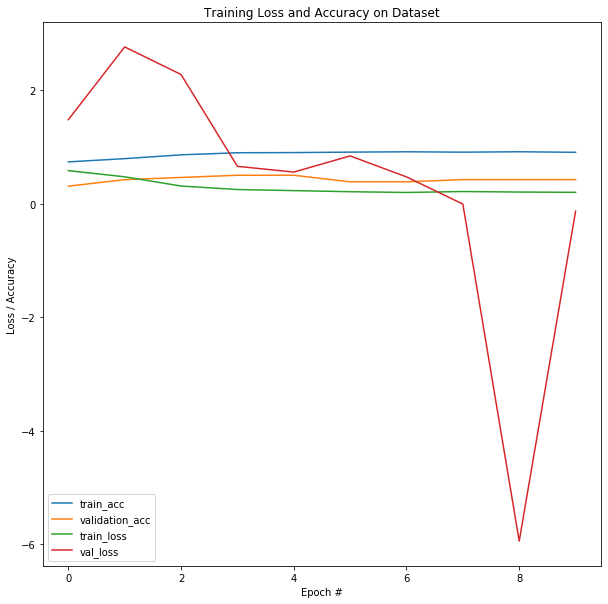

In [30]:
plt.figure(figsize = (10,10))
plt.plot(model2.history.history['accuracy'], label = "train_acc")
plt.plot(model2.history.history['val_accuracy'], label = "validation_acc")
plt.plot(model2.history.history['loss'], label = "train_loss")
plt.plot(model2.history.history['val_loss'], label = "val_loss")
plt.title('Training Loss and Accuracy on Dataset')
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='lower left')
plt.show()

In [62]:
model_new = load_model('model_PNEUCOVIDCOMPARE_attempt1 23.05.2020.model')

In [24]:
predictions = model2.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]